The first exercise of this homework contains small unrelated questions on code. The final exam may contain similar questions, in which you will be asked to analyze or correct a piece of code. 

The second exercise uses a physics dataset on which we perform linear classification.

In [1]:
# Python version 3.12.3

import pandas as pd
import numpy as np
np.random.seed(0)

import sklearn.model_selection as ms
import sklearn.linear_model as lm
import sklearn.preprocessing as pp
import matplotlib.pyplot as plt

## Exercise 1 (6 pt)

In [2]:
def loss(x, y, w, l):
    # x is a n \times d matrix, y is a vector
    return np.sum((y - x.dot(w))**2 / 2) + (l / 2) * np.sum(np.abs(w))

**Question 1 (1 pt)** What loss, seen in class, is computed by the function `loss` ? Explain in what contexts it is used, compared to other losses.

_Answer_ : This loss is called LASSO (section 3.5.3 of the course) and it features the typical squared error term but also an additional term called the "L1 regularization" term. The objective of this term is to penalize the sum of the absolute values of the weights $w$ to prevent them from growing to large and thus avoiding overfitting (which can happen for high-dimensional data).

The other common type of loss regression is the Ridge regression (L2 regularization) whose regularization term is given by $$\frac \lambda2 \sum_{j=1}^d w_j^2$$ This works well for multicollinearity (many features are correlated), but it may not simplify the model as well as LASSO when many features are irrelevant in high-dimensional data.

In [3]:
def ridge_estimator(x, y, l):
    n, d = x.shape
    return (x.T @ x + l * np.eye(d)) @ x.T @ y

**Question 2 (1 pt)** We want the function `ridge_estimator` defined above to compute the estimator that minimizes the Ridge loss. Is there any mistake in this code ? If yes, fix it.

_Answer_ : Yes, the definition above forgot the inversion term. The corrected version is given in the cell below

In [4]:
def ridge_estimator(x, y, l):
    n, d = x.shape
    return np.linalg.inv(x.T @ x + l * np.eye(d)) @ x.T @ y


In [5]:
def gradient_descent(x, y, B):
    """
    arguments:
        x -- n x d matrix
        y -- n vector
        B -- integer
    """
    # compute an estimator using gradient descent
    n, d = x.shape
    w = np.zeros(d) # Initialize weights
    tolerance = 1e-3
    diff = np.inf

    eta = 0.1 # = alpha (gradient descent rate)
    
    while diff > tolerance: # while old param are far from new params (convergence)
        w_old = np.copy(w)

        indices = np.random.choice(n, B)
        x_batch = x[indices]
        y_batch = y[indices]
        
        w -= eta * np.dot(x_batch.T, np.dot(x_batch, w) - y_batch) # Parameters update 

        diff = np.sum((w_old - w)**2) / d
    return w

**Question 3 (2 pt)** The goal of the function `gradient_descent` is to compute an estimator using stochastic gradient descent.

a) What is the value of the regularization here ? 

_Answer_ : The regularization term is 0 as there is no regularization considered when we update the weights $w$.

b) Explain the role of the variable `eta`. 

_Answer_ : The variable $\eta$ is called the "learning rate". It is a measure of how strongly we "penalize" the weights at each prediction. If $\eta$ is big, then every time our model predicts something a bit different ($\hat y$) than the ground truth ($y$), it will updated the parameters a lot. If $\eta$ is chosen to be small, then a when our model predicts something different from the ground truth, it will not update the parameters a lot.

c) What line(s) would you change (and how) to perform gradient descent instead of stochastic gradient descent ?

_Answer_ :  In gradient descent, we use the entire dataset to compute the gradient for each update, rather than using a randomly selected subset (batch) of the data during the stochastic gradient descent. The lines of code responsible for this are the ones randomly selecting a batch (np.random.choice(n,B)) instead of the whole dataset. The update is given in the cell below : 

In [6]:
def gradient_descent(x, y, B):
    """
    arguments:
        x -- n x d matrix
        y -- n vector
        B -- integer
    """
    # compute an estimator using gradient descent
    n, d = x.shape
    w = np.zeros(d) # Initialize weights
    tolerance = 1e-3
    diff = np.inf

    eta = 0.1 # = alpha (gradient descent rate)
    
    while diff > tolerance: # while old param are far from new params
        w_old = np.copy(w)

        indices = np.random.choice(n, B)
        # Remove x_batch = x[indices]
        # Remove y_batch = y[indices]
        
        w -= eta * np.dot(x.T, np.dot(x, w) - y) # Replace x_batch by x and similarly for y_batch and y.

        diff = np.sum((w_old - w)**2) / d
    return w

**Question 4 (2 pt)** In the function `gradient_logistic_l2`, implement the gradient of the following loss (as before, we use here labels equal to $\pm 1$) :
$$
    \mathcal{L}(\vec{w}) = \frac{1}{n} \left( \sum_{i = 1}^n \log \left( 1 + e^{- y_i \times \vec{w}^{\top} \vec{x}_i} \right) + \frac{\lambda}{2} \| \vec{w} \|^2 \right)
$$


In [7]:
def gradient_descent(x, y, lmbda):
    """
    Arguments:
        x -- n x d matrix of features
        y -- n vector 
        lmbda -- regularization parameter (we cannot write 'lambda' as it is a command for creating functions)
    """
    # Compute an estimator using batch gradient descent with L2 regularization
    n, d = x.shape
    w = np.zeros(d)
    tolerance = 1e-3
    diff = np.inf

    eta = 0.1  
    
    while diff > tolerance:
        w_old = np.copy(w)

        gradient = np.dot(x.T, np.dot(x, w) - y) / n + lmbda * w  # The derivative of the regularization term is added
        
        w -= eta * gradient

        diff = np.linalg.norm(w_old - w)

    return w


## Exercise 2 (10 pt)

In this exercise, we will perform linear classification on the SUSY dataset. Here, each data sample corresponds to particle collision event, which will be either from background noise (label `0`) or a supersymmetric event (label `1`). The input is made of $18$ numerical features related to the collision.

Because the original dataset is quite large (more than 1 GB), we will work with a small version of it containing 10000 training samples, that you can download on the Moodle page, called `susy_small.csv`.

### Data preparation

First, we will clean the data to make it more convenient to work with.

In [8]:
def load_dataset():
    df = pd.read_csv('susy_small.csv')
    # TODO your code here 
    x = df.iloc[:,1:]
    y = df.iloc[:,0]
    return x, y

# I have used ChatGPT to remind me the pandas function to select the columns 

**Question 1 (1 pt)** a) Implement the function `load_dataset` to return two numpy arrays `x` and `y`. `y` must contain the values in the column `SUSY` of the dataframe `df`, while `x` contains the rest of the data.

b) Observe the values taken by the labels $y$. Transform them such that they are either $-1$ or $1$ to be coherent with the notation seen in class.

In [9]:
def label_to_pm_one(y):
    y_new = y_new = y.replace(0, -1)
    return y_new

# I used ChatGPT to find the replace function and its input parameters

**Question 2 (1 pt)** As good practice, it is preferable to have normalized data that is to say that the mean of the input matrix `X` accross its first first dimension should be $0$, and its variance should be $1$. This is not the case here. We then want to write a function that does two things : 1) split the data into training and validation sets and 2) normalize the training data. 

Here are two possible functions, `function1` and `function2` written for this purpose. Which of them is preferrable to the other and why ? 

_Reminder_ : The function `sklearn.model_selection.train_test_split` splits a given dataset `X`, `y` into a training and test data. The role of  the argument `random_state=0` is for reproducibility purposes.

_Answer_ : function2 is the best one. In function1, we substract to "x_test" the value "mean_x_train" which does not make sense. It is preferable to substract to both "x_test" and "x_train" the mean of the whole dataset "mean_x" like it is done in function2. However, function 2 can be more elegantly written if we first normalize the whole dataset and then we split it into a training and a testing subset. 

In [10]:
def function1(x, y):
    # First split into training and validation, then compute the mean and variance of training data to normalize
    x_train, x_test, y_train, y_test = ms.train_test_split(x, y, test_size=0.2, random_state=0)
    mean_x_train = np.mean(x_train, axis = 0)
    var_x_train  = np.var(x_train, axis = 0)
    x_train = (x_train - mean_x_train) / np.sqrt(var_x_train)
    x_test  = (x_test  - mean_x_train) / np.sqrt(var_x_train)
    return x_train, x_test, y_train, y_test

def function2(x, y):
    # First compute the mean and variance of data, then split into training and validation
    mean_x = np.mean(x, axis = 0)
    var_x  = np.var(x, axis = 0)
    x_train, x_test, y_train, y_test = ms.train_test_split(x, y, test_size=0.2, random_state=0)
    x_train = (x_train - mean_x) / np.sqrt(var_x)
    x_test  = (x_test  - mean_x) / np.sqrt(var_x)
    return x_train, x_test, y_train, y_test

# function_normalize = function1
function_normalize = function2

### Logistic regression

**Question 4 (4 pt)** We want to run two methods to clasify the data : logistic regression with $\ell_1$ and $\ell_2$ penalty. 

a) First, implement the functions `logistic_l2` and `logistic_l1` that compute and returns the estimator for their corresponding losses. To this end, use the `sklearn.linear_model.LogisticRegression` class with the appropriate choice of penalty.

_Important note_ : in the initialization of `LogisticRegression`, set the argument `solver='liblinear'` to avoid an error.

In [11]:
def logistic_l1(x, y, lmbda):
    # Compute the estimator for logistic regression with L1 regularization (Lasso)
    """    
    Arguments:
        x: array, shape (n_samples, n_features)
        y: array, shape (n_samples,)
        lmbda: float
    """
    model = lm.LogisticRegression(penalty='l1', C=1/lmbda, solver='liblinear')
    model.fit(x, y)  
    return model

def logistic_l2(x, y, lmbda):
    # Compute the estimator for logistic regression with L1 regularization (Lasso)
    """    
    Arguments:
        x: array, shape (n_samples, n_features)
        y: array, shape (n_samples,)
        lmbda: float
    """
    model = lm.LogisticRegression(penalty='l2', C=1/lmbda, solver='liblinear')
    model.fit(x, y)  
    return model

# I used sklearn's online documentation


b) Implement the functions `logistic_l2_crossvalidation` and `logistic_l1_crossvalidation` that compute the accuracy on the _validation data_ of the estimators trained for different values of $\lambda$ : for a list `lambda_range` that contains a list of the $\lambda$ to be tested, the function should return another list of the same length that contains the accuracy for each $\lambda$.

In [12]:
from sklearn.metrics import accuracy_score

def logistic_l2_crossvalidation(x_train, y_train, x_val, y_val, lambda_range):
    #Accuracy of logistic regression with L2 regularization for different values of lambda on validation data.
    """
    Arguments:
        x_train, x_val: array, shape (n_samples, n_features)
        y_train, y_val: array, shape (n_samples,)
        lambda_range: list
    """
    accuracies = []
    
    for lmbda in lambda_range:
        model = logistic_l2(x_train, y_train, lmbda)
        
        y_pred = model.predict(x_val)
        accuracy = accuracy_score(y_val, y_pred) # Here I used the "accuracy_score" function from the sklearn.metrics documentation
        accuracies.append(accuracy) # Make a list of the accuracies for each value of lmbda
    
    return accuracies

def logistic_l1_crossvalidation(x_train, y_train, x_val, y_val, lambda_range):
    #Accuracy of logistic regression with L2 regularization for different values of lambda on validation data.
    """
    Arguments:
        x_train, x_val: array, shape (n_samples, n_features)
        y_train, y_val: array, shape (n_samples,)
        lambda_range: list
    """
    accuracies = []
    
    for lmbda in lambda_range:
        model = logistic_l1(x_train, y_train, lmbda)
        
        y_pred = model.predict(x_val)
        accuracy = accuracy_score(y_val, y_pred) # Here I used the "accuracy_score" function from the sklearn.metrics documentation
        accuracies.append(accuracy) # Make a list of the accuracies for each value of lmbda
    
    return accuracies



c) Using the functions of the previous questions, plot the validation accuracy for `lambda_range = np.logspace(-2, 5, 50)` for both $\ell_1$ and $\ell_2$ regularizations (don't hesitate to use a logarithmic scale for the x-axis). What are the optimal values $\lambda_1, \lambda_2$ ? 

_Answer_ : The optimal values are 
- $\lambda = 37.27593720314938$ for L1 regularization
- $\lambda = 26.826957952797247$ for L2 regularization


In [13]:
# Initialize lambda_range
lambda_range = np.logspace(-2,5,50)

# 1) load the data and normalize it
x,y = load_dataset()
y_new = label_to_pm_one(y)
x_train, x_test, y_train, y_test = function_normalize(x,y_new)

# 2) compute the scores for logistic regression with l1 penalty
accL1 = logistic_l1_crossvalidation(x_train, y_train, x_test, y_test, lambda_range)

# 3) compute the scores for logistic regression with l2 penalty
accL2 = logistic_l2_crossvalidation(x_train, y_train, x_test, y_test, lambda_range)




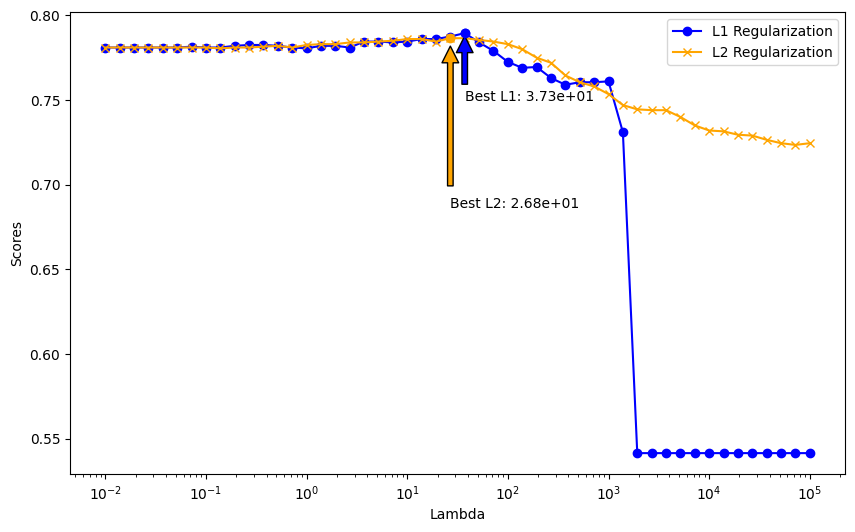

Best lambda for l1 is 37.27593720314938
Best lambda for l2 is 26.826957952797247


In [14]:
# 4) plot the scores as a function of lambda_range
plt.figure(figsize=(10, 6))
plt.plot(lambda_range, accL1, label='L1 Regularization', color='blue', marker='o')
plt.plot(lambda_range, accL2, label='L2 Regularization', color='orange', marker='x')

index_bestL1 = np.argmax(accL1)
index_bestL2 = np.argmax(accL2)
bestL1 = lambda_range[index_bestL1]
bestL2 = lambda_range[index_bestL2]

plt.scatter(bestL1, accL1[index_bestL1], color='blue', zorder=5)
plt.annotate(f'Best L1: {bestL1:.2e}',
            xy=(bestL1, accL1[index_bestL1]), 
            xytext=(bestL1, accL1[index_bestL1] -0.04),  # Adjust position of the text
            arrowprops=dict(facecolor='blue', shrink=0.05),
            fontsize=10)

# Highlight the best lambda for L2 with annotate (arrow)
plt.scatter(bestL2, accL2[index_bestL2], color='orange', zorder=5)
plt.annotate(f'Best L2: {bestL2:.2e}',
            xy=(bestL2, accL2[index_bestL2]), 
            xytext=(bestL2, accL2[index_bestL2] - 0.10),  # Adjust position of the text
            arrowprops=dict(facecolor='orange', shrink=0.05),
            fontsize=10)

plt.xscale('log')
plt.ylabel("Scores")
plt.xlabel("Lambda")
plt.legend()
plt.show()

# 5) print the best lambda for l1 and l2 penalties
print(f"Best lambda for l1 is {bestL1}",)
print(f"Best lambda for l2 is {bestL2}",)

# I used ChatGPT to help me with the plotting (plt.annotate arguments)

d) When $\lambda$ is big enough, the validation accuracy for $\ell_1$ regularization becomes constant to some value (let's call it $acc_{\infty}$). Justify that $acc_{\infty}$ is equal to the proportion of background events (i.e samples with label $-1$) in the validation data.

_Answer_ : In the case where $\lambda$ is very large, the regularization term dominates the loss function. This means that all the weights tend to $0$, only leaving the bias term non-zero. It implies that the model's prediction becomes independent of the input data and then it outputs a constant value (this is called a constant predictor). We can compute the optimal value for such bias term in a 2-label classification proble and we find that it is equal to the mean of the labels. Thus, if one label is more present than the other (background events in our case), the constant prediction will correspond to the most frequent class. As we have $a_{acc} = 0.5415$ we can then infer that the $-1$ label composes 54.15% of the dataset

### Adding interacting polynomial features

In this section, we will try to improve our classifier by adding features in our data, namely the product of the 18 existing features. That is to say, for all pair of indices $0 \leqslant i, j \leqslant 17$ with $i \neq j$ we will add the feature `X[:, i] * X[:, j]` to the matrix `X` (to have 171 features in total).

**Question 5 (1 pt)** Implement the function `add_interactions` to add the features described above.

_Hint_ : You can use a class seen in the exercise session to do so, with the correct arguments `degree` and `interaction_only`. The final dimension should be 171.


In [19]:
def add_interactions(X):
    poly = pp.PolynomialFeatures(degree=2, interaction_only=True, include_bias=False) #include_bias = False as otherwise we have an error
    return poly.fit_transform(X)

**Question 6 (3 pt)** Redo the steps of question 3 and 4 to find the optimal regularization strength $\lambda_{1, poly}$ and $\lambda_{2, poly}$ that correspond to the best validation accuracy. Did the validation accuracy improve compared to question 4 ? 

_NOTE_ : The computation may take some time, so be patient.

_Answer_ : Yes the accuracy improved a little bit :
- Accuracy for optimal value of $\lambda$ in L1 regularization: $0.7895$
- Accuracy for optimal value of $\lambda$ in L1 regularization for polynomial features: $0.7975$
- Accuracy for optimal value of $\lambda$ in L2 regularization: $0.7865$
- Accuracy for optimal value of $\lambda$ in L2 regularization for polynomial features: $0.797$

However, the computation time is way superior when we considered polynomial features which implies a computation time - accuracy trade-off.

In [18]:

# Re-initialize lambda_range (not needed but good to recall it)
lambda_range = np.logspace(-2,5,50)

# 1) load the data and normalize it
x,y = load_dataset()
x_interactions = add_interactions(x)
y_new = label_to_pm_one(y)
x_train_poly, x_test_poly, y_train_poly, y_test_poly = function_normalize(x_interactions,y_new)

# 2) compute the scores for logistic regression with l1 penalty
accL1_poly = logistic_l1_crossvalidation(x_train_poly, y_train_poly, x_test_poly, y_test_poly, lambda_range)

# 3) compute the scores for logistic regression with l2 penalty
accL2_poly = logistic_l2_crossvalidation(x_train_poly, y_train_poly, x_test_poly, y_test_poly, lambda_range)

# Total time run for model training: 15m53s



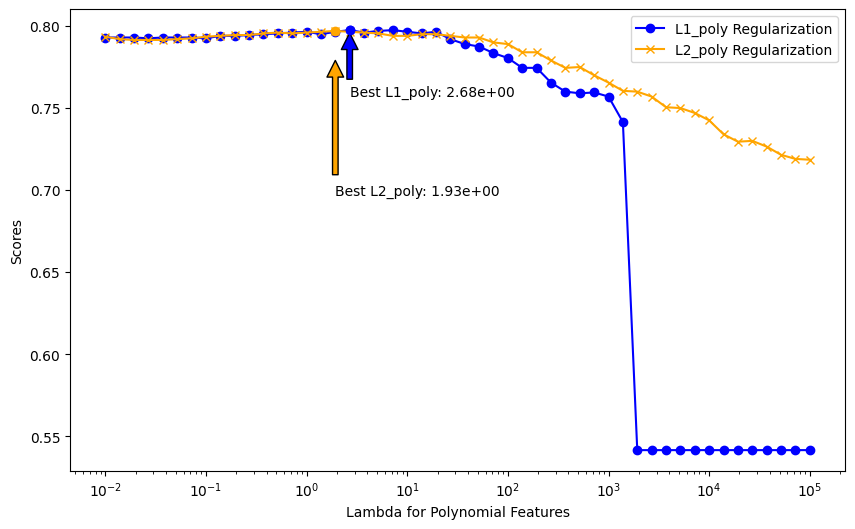

Best lambda for l1_poly is 37.27593720314938
Best lambda for l2_poly is 26.826957952797247


In [22]:

plt.figure(figsize=(10, 6))
plt.plot(lambda_range, accL1_poly, label='L1_poly Regularization', color='blue', marker='o')
plt.plot(lambda_range, accL2_poly, label='L2_poly Regularization', color='orange', marker='x')

index_bestL1_poly = np.argmax(accL1_poly)
index_bestL2_poly = np.argmax(accL2_poly)
bestL1_poly = lambda_range[index_bestL1_poly]
bestL2_poly = lambda_range[index_bestL2_poly]

plt.scatter(bestL1_poly, accL1_poly[index_bestL1_poly], color='blue', zorder=5)
plt.annotate(f'Best L1_poly: {bestL1_poly:.2e}',
            xy=(bestL1_poly, accL1_poly[index_bestL1_poly]), 
            xytext=(bestL1_poly, accL1_poly[index_bestL1_poly] -0.04),  # Adjust position of the text
            arrowprops=dict(facecolor='blue', shrink=0.05),
            fontsize=10)

# Highlight the best lambda for L2 with annotate (arrow)
plt.scatter(bestL2_poly, accL2_poly[index_bestL2_poly], color='orange', zorder=5)
plt.annotate(f'Best L2_poly: {bestL2_poly:.2e}',
            xy=(bestL2_poly, accL2[index_bestL2_poly]), 
            xytext=(bestL2_poly, accL2_poly[index_bestL2_poly] - 0.10),  # Adjust position of the text
            arrowprops=dict(facecolor='orange', shrink=0.05),
            fontsize=10)

plt.xscale('log')
plt.ylabel("Scores")
plt.xlabel("Lambda for Polynomial Features")
plt.legend()
plt.show()

# 5) print the best lambda for l1 and l2 penalties
print(f"Best lambda for l1_poly is {bestL1}",)
print(f"Best lambda for l2_poly is {bestL2}",)

# I used ChatGPT to help me with the plotting (plt.annotate)
